# 1) Read the tabular data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("exo3.csv")
df

,Age,Income,Student,Credit_rating,Buys_computer
0,<=30,Hight,No,Fair,No
1,<=30,Hight,No,Excellent,No
2,31...40,Hight,No,Fair,Yes
3,>40,Medium,No,Fair,Yes
4,>40,Low,Yes,Fair,Yes
5,>40,Low,Yes,Excellent,No
6,31...40,Low,Yes,Excellent,Yes
7,<=30,Medium,No,Fair,No
8,<=30,Low,Yes,Fair,Yes
9,>30,Medium,Yes,Fair,Yes


# 2) Generate the optimal split Decision Tree based on entropy

In [2]:
def entropy(ni, n):
    if ni == 0 or ni == n:
        return 0
    tmp =  ni / n
    return - tmp * np.log2(tmp)


def computeNodeEntropy(node, label):
    e, n = 0, len(node)
    for c in node[label].unique(): # loop trough each class
        node_i = node[node[label] == c]
        n_i = len(node_i)
        e_i = entropy(n_i, n)
        e += e_i
        #print(f"{c} : {n_i}/{n} -> ei={e_i:.2f}")
    #print(f'entropy = {e:.2f}\n')
    return e
        

def DecisionTree(t , label):
    # get repartion of the label
    classes = t[label].unique()
    if len(classes) == 1: return classes[0]
    
    # compute the base node entropy
    H = computeNodeEntropy(t, label)
    #print(f'H : {H}')
    n = len(t)
    
    #if H == 0:
    #    print(len(classes))
    #    print(classes)
    #    raise Exception('H == 0')
    #    return classes
        
    # retrieve all the features that can be splited on
    features = t.columns.to_numpy().tolist()
    try:
        features.remove(label)
    except ValueError:
        raise Exception('label not present !')
    #print(features)
    
    # find the best split
    split_opti = None
    gain_split_max = 0
    for split in features:
        split_classes = t[split].unique()
        gain_split = H
        
        for split_class in split_classes:
            #print(f"{split} : '{split_class}'")
            ti = t[t[split] == split_class]
            ni = len(ti)
            ei = computeNodeEntropy(ti, label)
            #print(ni, ei)
            gain_split -= (ni/n) * ei

        #print('gain_split', gain_split)
        if gain_split > gain_split_max:
            gain_split_max = gain_split
            split_opti = split
        #print()
    
    #print(f"features : {features}")
    #print(f'best split feature : {split_opti}')
    out = {split_opti : {}}
    for split_class in t[split_opti].unique():
        ti = t[t[split_opti] == split_class]
        ti = ti.drop(split_opti, inplace=False, axis=1)
        
        out[split_opti][split_class] = DecisionTree(ti, label)
        
    return out
        

tree = DecisionTree(df, 'Buys_computer')
print(tree)

{'Age': {'<=30': {'Student': {'No': 'No', 'Yes': 'Yes'}}, '31...40': 'Yes', '>40': {'Credit_rating': {'Fair': 'Yes', 'Excellent': 'No'}}, '>30': 'Yes'}}


## 3) Plot the Tree `conda install graphviz`

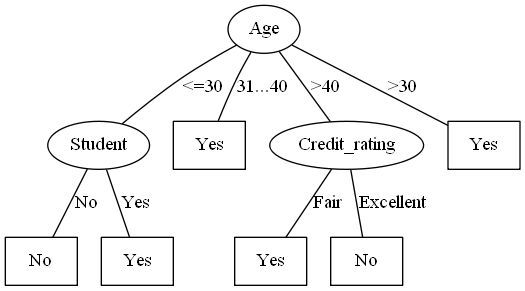

In [3]:
import pydot
import uuid
from IPython.display import Image

def generate_unique_node():
    """ Generate a unique node label."""
    return str(uuid.uuid1())

def create_node(graph, label, shape='oval'):
    node = pydot.Node(generate_unique_node(), label=label, shape=shape)
    graph.add_node(node)
    return node

def create_edge(graph, node_parent, node_child, label):
    link = pydot.Edge(node_parent, node_child, label=label)
    graph.add_edge(link)
    return link

def walk_tree(graph, dictionary, prev_node=None):
    """ Recursive construction of a decision tree stored as a dictionary """
    for parent, child in dictionary.items():
        # root
        if not prev_node: 
            root = create_node(graph, parent)
            walk_tree(graph, child, root)
            continue
            
        # node
        if isinstance(child, dict):
            for p, c in child.items():
                n = create_node(graph, p)
                create_edge(graph, prev_node, n, str(parent))
                walk_tree(graph, c, n)
    
        # leaf
        else: 
            leaf = create_node(graph, str(child), shape='box')
            create_edge(graph, prev_node, leaf, str(parent))

def plot_tree(dictionary, filename="DecisionTree.png"):
    graph = pydot.Dot(graph_type='graph')
    walk_tree(graph, tree)
    graph.write_png(filename)
        

plot_tree(tree, filename="exo3.png")
Image("exo3.png")
